In [ ]:
!pip install -U datasets huggingface_hub fsspec transformers scikit-learn

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 40.9/40.9 kB 3.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 494.8/494.8 kB 17.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 193.6/193.6 kB 18.0 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 10.8/10.8 MB 79.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 9.7/9.7 MB 87.0 MB/s eta 0:00:00
  Attempting uninstall: fsspec
    Found existing installation: fsspec 2025.7.0
    Uninstalling fsspec-2025.7.0:
      Successfully uninstalled fsspec-2025.7.0
  Attempting uninstall: scikit-learn
    Found existing installation: scikit-learn 1.6.1
    Uninstalling scikit-learn-1.6.1:
      Successfully uninstalled scikit-learn-1.6.1
  Attempting uninstall: transformers
    Found existing installation: transformers 4.53.2
    Uninstalling transformers-4.53.2:
      Successfully uninstalled transformers-4.53.2
  Attempting uninstall: datasets
    Found existing installation: datasets 2.14.4
    

# Imports

In [ ]:
import torch
import torch.nn as nn
import numpy as np
import matplotlib.pyplot as plt
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import DataLoader, random_split
from datasets import load_dataset
from torch.optim import AdamW

# Load dataset and label information

In [ ]:
dataset = load_dataset("dair-ai/emotion")
target_names = ["sadness", "joy", "love", "anger", "fear", "surprise"]
label_ids = list(range(6))

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/1.03M [00:00<?, ?B/s]

validation-00000-of-00001.parquet:   0%|          | 0.00/127k [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/129k [00:00<?, ?B/s]

Generating train split:   0%|          | 0/16000 [00:00<?, ? examples/s]

Generating validation split:   0%|          | 0/2000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/2000 [00:00<?, ? examples/s]

## Tokenizer and Pre-process

In [ ]:
model_id = "google/electra-small-discriminator"
tokenizer = AutoTokenizer.from_pretrained(model_id)
model = AutoModelForSequenceClassification.from_pretrained(model_id, num_labels=6)

# Tokenize dataset
def tokenize(batch):
    return tokenizer(batch["text"], padding="max_length", truncation=True, max_length=128)

encoded_dataset = dataset.map(tokenize, batched=True)
encoded_dataset.set_format(type="torch", columns=["input_ids", "attention_mask", "label"])

tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/665 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

pytorch_model.bin:   0%|          | 0.00/54.2M [00:00<?, ?B/s]

Some weights of ElectraForSequenceClassification were not initialized from the model checkpoint at google/electra-small-discriminator and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/54.2M [00:00<?, ?B/s]

Map:   0%|          | 0/16000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

Map:   0%|          | 0/2000 [00:00<?, ? examples/s]

In [ ]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

ElectraForSequenceClassification(
  (electra): ElectraModel(
    (embeddings): ElectraEmbeddings(
      (word_embeddings): Embedding(30522, 128, padding_idx=0)
      (position_embeddings): Embedding(512, 128)
      (token_type_embeddings): Embedding(2, 128)
      (LayerNorm): LayerNorm((128,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (embeddings_project): Linear(in_features=128, out_features=256, bias=True)
    (encoder): ElectraEncoder(
      (layer): ModuleList(
        (0-11): 12 x ElectraLayer(
          (attention): ElectraAttention(
            (self): ElectraSelfAttention(
              (query): Linear(in_features=256, out_features=256, bias=True)
              (key): Linear(in_features=256, out_features=256, bias=True)
              (value): Linear(in_features=256, out_features=256, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): ElectraSelfOutput(
              (dense): Li

In [ ]:
train_size = int(0.8 * len(encoded_dataset["train"]))
val_size = len(encoded_dataset["train"]) - train_size

train_dataset, val_dataset = random_split(encoded_dataset["train"], [train_size, val_size])

train_loader = DataLoader(train_dataset, batch_size=16, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=16)
optimizer = AdamW(model.parameters(), lr=2e-5)
loss_fn = nn.CrossEntropyLoss()

# Training Loop

In [ ]:
model.train()
for epoch in range(10):
    total_loss = 0
    for batch in train_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        optimizer.zero_grad()
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        loss = loss_fn(outputs.logits, labels)
        loss.backward()
        optimizer.step()
        total_loss += loss.item()

    avg_train_loss = total_loss / len(train_loader)

    model.eval()
    val_loss = 0
    with torch.no_grad():
        for batch in val_loader:
            input_ids = batch["input_ids"].to(device)
            attention_mask = batch["attention_mask"].to(device)
            labels = batch["label"].to(device)

            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            loss = loss_fn(outputs.logits, labels)
            val_loss += loss.item()

    avg_val_loss = val_loss / len(val_loader)

    print(f"Epoch {epoch+1} - Training Loss: {avg_train_loss:.4f} | Validation Loss: {avg_val_loss:.4f}")

Epoch 1 - Training Loss: 0.0670 | Validation Loss: 0.0445
Epoch 2 - Training Loss: 0.0373 | Validation Loss: 0.0546
Epoch 3 - Training Loss: 0.0282 | Validation Loss: 0.0546
Epoch 4 - Training Loss: 0.0228 | Validation Loss: 0.0658
Epoch 5 - Training Loss: 0.0217 | Validation Loss: 0.0963
Epoch 6 - Training Loss: 0.0145 | Validation Loss: 0.0918
Epoch 7 - Training Loss: 0.0099 | Validation Loss: 0.0842
Epoch 8 - Training Loss: 0.0155 | Validation Loss: 0.1012
Epoch 9 - Training Loss: 0.0201 | Validation Loss: 0.0958
Epoch 10 - Training Loss: 0.0105 | Validation Loss: 0.1099


# Check on test set

In [ ]:
model.eval()

y_true = []
y_pred = []

test_loader = torch.utils.data.DataLoader(encoded_dataset["test"], batch_size=32)

with torch.no_grad():
    for batch in test_loader:
        input_ids = batch["input_ids"].to(device)
        attention_mask = batch["attention_mask"].to(device)
        labels = batch["label"].to(device)

        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)

        y_true.extend(labels.cpu().numpy())
        y_pred.extend(predictions.cpu().numpy())


 Classification Report:
              precision    recall  f1-score   support

     sadness       0.97      0.97      0.97       581
         joy       0.93      0.98      0.95       695
        love       0.91      0.74      0.82       159
       anger       0.96      0.93      0.94       275
        fear       0.90      0.92      0.91       224
    surprise       0.83      0.74      0.78        66

    accuracy                           0.94      2000
   macro avg       0.92      0.88      0.90      2000
weighted avg       0.94      0.94      0.94      2000



<Figure size 800x600 with 0 Axes>

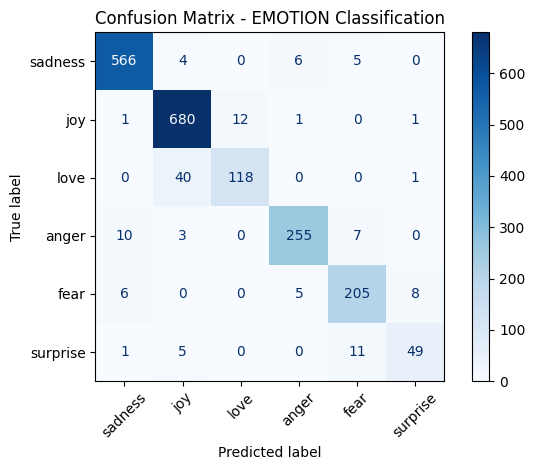

In [ ]:
print("\n Classification Report:")
print(classification_report(
    y_true, y_pred,
    labels=label_ids,
    target_names=target_names,
    zero_division=0  # avoids undefined metric warnings
))

cm = confusion_matrix(y_true, y_pred, labels=label_ids)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=target_names)

plt.figure(figsize=(8, 6))
disp.plot(cmap="Blues", xticks_rotation=45)
plt.title("Confusion Matrix - EMOTION Classification")
plt.tight_layout()
plt.show()